<a href="https://colab.research.google.com/github/t-tsue/public/blob/main/PBL02_sample_vith14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
DIR='/content/drive/My Drive/DXQuest_PBL02/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

train_files = glob.glob(os.path.join(DIR,'train_conv', '*/*.jpeg'))
test_files = sorted(glob.glob(os.path.join(DIR,'test_conv', '*.jpeg')))

train_df = pd.DataFrame(train_files, columns=['file_name'])
test_df = pd.DataFrame(test_files, columns=['file_name'])

In [3]:
def get_label(x):
  if 'bridge' in x:
    return 1
  elif 'horn' in x:
    return 2
  elif 'potato' in x:
    return 3
  else:
    return 0

train_df['label'] = train_df['file_name'].apply(get_label)

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import random
import torch.utils.data as data
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

In [6]:
SIZE = 518
CSIZE = 518
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class ImageTransform():
  def __init__(self, phase, resize = SIZE, csize=CSIZE, mean = MEAN, std = STD):
    self.phase = phase
    if phase == 'train':
      self.data_transform = transforms.Compose([
          transforms.RandomResizedCrop(resize,scale=(0.9,1)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(-10,10)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
    else:
      self.data_transform = transforms.Compose([
          transforms.Resize(resize),
          transforms.CenterCrop(csize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
class CustomDataset(Dataset):
  def __init__(self, df, phase='train'):
    self.df = df
    self.transform = ImageTransform(phase)
    self.phase = phase

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if self.phase != 'test':
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      label = self.df.iloc[index]['label']
      return img_transformed, label
    else:
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      return img_transformed


In [8]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
  best_loss = 99
  best_acc = 0
  scores=[]
  net.to(device)
  # epochのループ
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()  # モデルを訓練モードに
      else:
        net.eval()   # モデルを検証モードに

      # epochごとの学習と検証のループ

      epoch_loss = 0.0  # epochの損失和
      epoch_corrects = 0  # epochの正解数


      # データローダーからミニバッチを取り出すループ
      dataloader = dataloader_dict[phase]
      for inputs, labels in tqdm(dataloader):

        # optimizerを初期化
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)  # 損失を計算
          _, preds = torch.max(outputs, 1)  # ラベルを予測


          # 訓練時はバックプロパゲーション
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # イタレーション結果の計算
          # lossの合計を更新
          epoch_loss += loss.item() * inputs.size(0)
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epochごとのlossと正解率を表示
      epoch_loss = epoch_loss / len(dataloader.dataset)
      epoch_acc = epoch_corrects.double(
      ) / len(dataloader.dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      if phase == 'val':
        if epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_loss.pth'))
          net.to(device)
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_acc.pth'))
          net.to(device)
      scores.append([epoch, phase, epoch_loss, epoch_acc])
  return net, pd.DataFrame(scores, columns=['epoch', 'phase', 'loss', 'acc'])

In [9]:
BATCH_SIZE = 40
EPOCHS = 30
LEARNING_RATE = 0.001
#MOMENTUM = 0.9

def get_model():
  weights = models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1  # 学習済みのパラメータを使用
  net = models.vit_h_14(weights=weights)
  net.heads.head = nn.Linear(in_features=1280, out_features=4, bias=True)
  return net

def get_criterion():
  criterion = nn.CrossEntropyLoss()
  return criterion

def get_optimizer(net):
  params_to_update = []

  update_param_names = ["heads.head.weight", "heads.head.bias"]

  for name, param in net.named_parameters():
    if name in update_param_names:
      param.requires_grad = True
      params_to_update.append(param)
    else:
      param.requires_grad = False

  optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, )
  return optimizer

In [10]:
def predict(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  return np.argmax(np.array(result),axis=1)

def predict_proba(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  result = np.array(result)
  pred_0 = result[:,0]
  pred_1 = result[:,1]
  return np.exp(pred_1)/(np.exp(pred_0)+np.exp(pred_1))

def get_score(y_true, y_pred):
  y_true = (y_true > 0).astype(int)
  y_pred = (y_pred > 0).astype(int)
  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return [acc, recall, precision, f1]

SEED=42

def init_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

for seed in range(1):
  seed = SEED + seed
  init_seed(seed)
  g = torch.Generator()
  g.manual_seed(seed)
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
  X = train_df
  y = train_df['label']
  MODEL_DIR=os.path.join(DIR,'model')
  os.makedirs(MODEL_DIR, exist_ok=True)
  for iter, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    train_dataset = CustomDataset(X_train, phase='train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    val_dataset = CustomDataset(X_val, phase='val')
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    net = get_model()
    criterion = get_criterion()
    optimizer = get_optimizer(net)
    dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}
    net,score = train_model(net, dataloader_dict, criterion, optimizer, EPOCHS)
    torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_{iter}.pth'))
    break

Epoch 1/30
-------------


100%|██████████| 6/6 [03:47<00:00, 37.99s/it]


train Loss: 1.4139 Acc: 0.3836


100%|██████████| 2/2 [00:45<00:00, 22.93s/it]


val Loss: 1.3551 Acc: 0.3793
Epoch 2/30
-------------


100%|██████████| 6/6 [03:51<00:00, 38.58s/it]


train Loss: 1.2705 Acc: 0.4440


100%|██████████| 2/2 [00:44<00:00, 22.02s/it]


val Loss: 1.2146 Acc: 0.4310
Epoch 3/30
-------------


100%|██████████| 6/6 [03:54<00:00, 39.08s/it]


train Loss: 1.1395 Acc: 0.5043


100%|██████████| 2/2 [00:43<00:00, 21.94s/it]


val Loss: 1.0367 Acc: 0.5517
Epoch 4/30
-------------


100%|██████████| 6/6 [03:53<00:00, 38.96s/it]


train Loss: 1.0622 Acc: 0.5474


100%|██████████| 2/2 [00:43<00:00, 21.97s/it]


val Loss: 1.0737 Acc: 0.5000
Epoch 5/30
-------------


100%|██████████| 6/6 [03:44<00:00, 37.47s/it]


train Loss: 0.9957 Acc: 0.5991


100%|██████████| 2/2 [00:45<00:00, 22.50s/it]


val Loss: 1.0064 Acc: 0.6207
Epoch 6/30
-------------


100%|██████████| 6/6 [03:50<00:00, 38.48s/it]


train Loss: 0.8832 Acc: 0.6767


100%|██████████| 2/2 [00:44<00:00, 22.07s/it]


val Loss: 0.9749 Acc: 0.6552
Epoch 7/30
-------------


100%|██████████| 6/6 [03:53<00:00, 38.91s/it]


train Loss: 0.8976 Acc: 0.6250


100%|██████████| 2/2 [00:45<00:00, 22.72s/it]


val Loss: 0.9397 Acc: 0.6379
Epoch 8/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.52s/it]


train Loss: 0.8804 Acc: 0.6293


100%|██████████| 2/2 [00:44<00:00, 22.37s/it]


val Loss: 0.9157 Acc: 0.6552
Epoch 9/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.60s/it]


train Loss: 0.7989 Acc: 0.7026


100%|██████████| 2/2 [00:45<00:00, 22.80s/it]


val Loss: 0.8775 Acc: 0.6724
Epoch 10/30
-------------


100%|██████████| 6/6 [03:52<00:00, 38.82s/it]


train Loss: 0.7922 Acc: 0.6940


100%|██████████| 2/2 [00:44<00:00, 22.03s/it]


val Loss: 0.8796 Acc: 0.6552
Epoch 11/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.53s/it]


train Loss: 0.7684 Acc: 0.7457


100%|██████████| 2/2 [00:44<00:00, 22.41s/it]


val Loss: 0.8672 Acc: 0.6552
Epoch 12/30
-------------


100%|██████████| 6/6 [03:44<00:00, 37.42s/it]


train Loss: 0.7169 Acc: 0.7457


100%|██████████| 2/2 [00:45<00:00, 22.74s/it]


val Loss: 0.8911 Acc: 0.6379
Epoch 13/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.65s/it]


train Loss: 0.6946 Acc: 0.7845


100%|██████████| 2/2 [00:44<00:00, 22.06s/it]


val Loss: 0.8272 Acc: 0.6724
Epoch 14/30
-------------


100%|██████████| 6/6 [03:43<00:00, 37.27s/it]


train Loss: 0.6557 Acc: 0.7716


100%|██████████| 2/2 [00:44<00:00, 22.16s/it]


val Loss: 0.7966 Acc: 0.6897
Epoch 15/30
-------------


100%|██████████| 6/6 [03:52<00:00, 38.82s/it]


train Loss: 0.6850 Acc: 0.7586


100%|██████████| 2/2 [00:45<00:00, 22.66s/it]


val Loss: 0.8114 Acc: 0.6552
Epoch 16/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.57s/it]


train Loss: 0.6442 Acc: 0.7802


100%|██████████| 2/2 [00:44<00:00, 22.13s/it]


val Loss: 0.8366 Acc: 0.6379
Epoch 17/30
-------------


100%|██████████| 6/6 [03:46<00:00, 37.74s/it]


train Loss: 0.6120 Acc: 0.7888


100%|██████████| 2/2 [00:44<00:00, 22.06s/it]


val Loss: 0.7829 Acc: 0.6552
Epoch 18/30
-------------


100%|██████████| 6/6 [03:44<00:00, 37.38s/it]


train Loss: 0.6185 Acc: 0.7888


100%|██████████| 2/2 [00:44<00:00, 22.08s/it]


val Loss: 0.8187 Acc: 0.6552
Epoch 19/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.51s/it]


train Loss: 0.5903 Acc: 0.7931


100%|██████████| 2/2 [00:44<00:00, 22.48s/it]


val Loss: 0.7701 Acc: 0.7069
Epoch 20/30
-------------


100%|██████████| 6/6 [03:52<00:00, 38.77s/it]


train Loss: 0.6028 Acc: 0.7845


100%|██████████| 2/2 [00:45<00:00, 22.73s/it]


val Loss: 0.7968 Acc: 0.6897
Epoch 21/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.52s/it]


train Loss: 0.5469 Acc: 0.8233


100%|██████████| 2/2 [00:43<00:00, 21.98s/it]


val Loss: 0.7788 Acc: 0.6724
Epoch 22/30
-------------


100%|██████████| 6/6 [03:44<00:00, 37.47s/it]


train Loss: 0.5685 Acc: 0.8017


100%|██████████| 2/2 [00:45<00:00, 22.72s/it]


val Loss: 0.7801 Acc: 0.7069
Epoch 23/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.66s/it]


train Loss: 0.5790 Acc: 0.8060


100%|██████████| 2/2 [00:44<00:00, 22.10s/it]


val Loss: 0.7579 Acc: 0.7241
Epoch 24/30
-------------


100%|██████████| 6/6 [03:51<00:00, 38.64s/it]


train Loss: 0.5928 Acc: 0.7931


100%|██████████| 2/2 [00:44<00:00, 22.08s/it]


val Loss: 0.7691 Acc: 0.7414
Epoch 25/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.50s/it]


train Loss: 0.5249 Acc: 0.8362


100%|██████████| 2/2 [00:44<00:00, 22.09s/it]


val Loss: 0.7662 Acc: 0.7069
Epoch 26/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.58s/it]


train Loss: 0.5338 Acc: 0.8448


100%|██████████| 2/2 [00:45<00:00, 22.84s/it]


val Loss: 0.7447 Acc: 0.7241
Epoch 27/30
-------------


100%|██████████| 6/6 [03:46<00:00, 37.76s/it]


train Loss: 0.5210 Acc: 0.8448


100%|██████████| 2/2 [00:45<00:00, 22.81s/it]


val Loss: 0.7467 Acc: 0.7069
Epoch 28/30
-------------


100%|██████████| 6/6 [03:46<00:00, 37.71s/it]


train Loss: 0.4707 Acc: 0.8879


100%|██████████| 2/2 [00:43<00:00, 21.96s/it]


val Loss: 0.7497 Acc: 0.6552
Epoch 29/30
-------------


100%|██████████| 6/6 [03:45<00:00, 37.52s/it]


train Loss: 0.5034 Acc: 0.8491


100%|██████████| 2/2 [00:45<00:00, 22.52s/it]


val Loss: 0.7635 Acc: 0.6897
Epoch 30/30
-------------


100%|██████████| 6/6 [03:46<00:00, 37.71s/it]


train Loss: 0.4862 Acc: 0.8621


100%|██████████| 2/2 [00:45<00:00, 22.91s/it]


val Loss: 0.7678 Acc: 0.6897


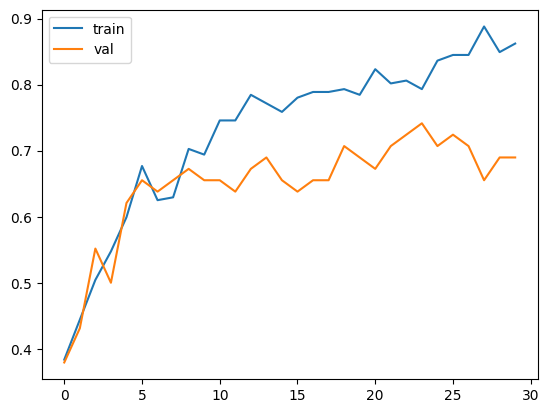

In [11]:
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
plt.plot(score_train['epoch'], score_train['acc'], label='train')
plt.plot(score_test['epoch'], score_test['acc'], label='val')
plt.legend()
plt.show()

In [12]:
for name, param in net.named_parameters():
  print(name)

class_token
conv_proj.weight
conv_proj.bias
encoder.pos_embedding
encoder.layers.encoder_layer_0.ln_1.weight
encoder.layers.encoder_layer_0.ln_1.bias
encoder.layers.encoder_layer_0.self_attention.in_proj_weight
encoder.layers.encoder_layer_0.self_attention.in_proj_bias
encoder.layers.encoder_layer_0.self_attention.out_proj.weight
encoder.layers.encoder_layer_0.self_attention.out_proj.bias
encoder.layers.encoder_layer_0.ln_2.weight
encoder.layers.encoder_layer_0.ln_2.bias
encoder.layers.encoder_layer_0.mlp.0.weight
encoder.layers.encoder_layer_0.mlp.0.bias
encoder.layers.encoder_layer_0.mlp.3.weight
encoder.layers.encoder_layer_0.mlp.3.bias
encoder.layers.encoder_layer_1.ln_1.weight
encoder.layers.encoder_layer_1.ln_1.bias
encoder.layers.encoder_layer_1.self_attention.in_proj_weight
encoder.layers.encoder_layer_1.self_attention.in_proj_bias
encoder.layers.encoder_layer_1.self_attention.out_proj.weight
encoder.layers.encoder_layer_1.self_attention.out_proj.bias
encoder.layers.encoder_lay